The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


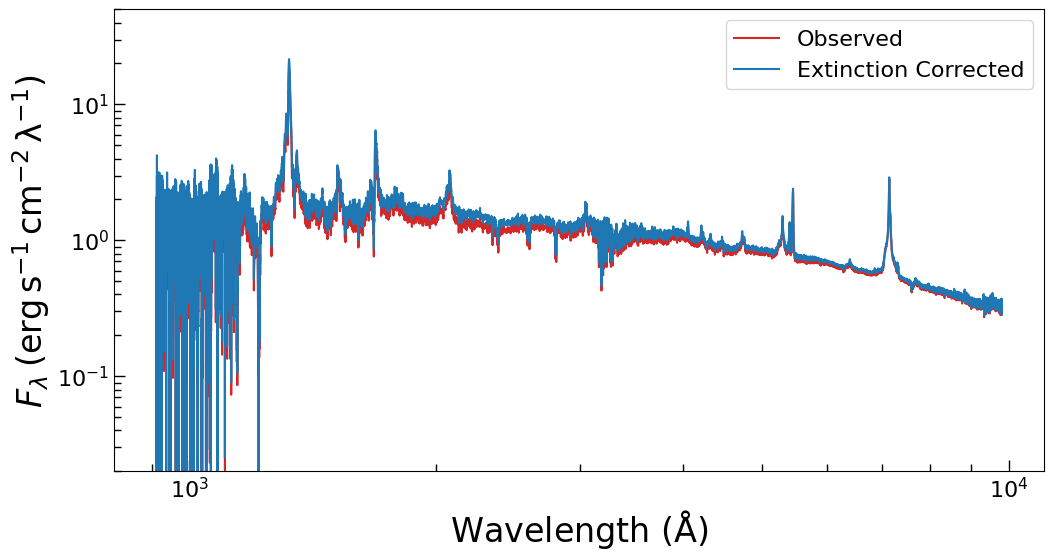

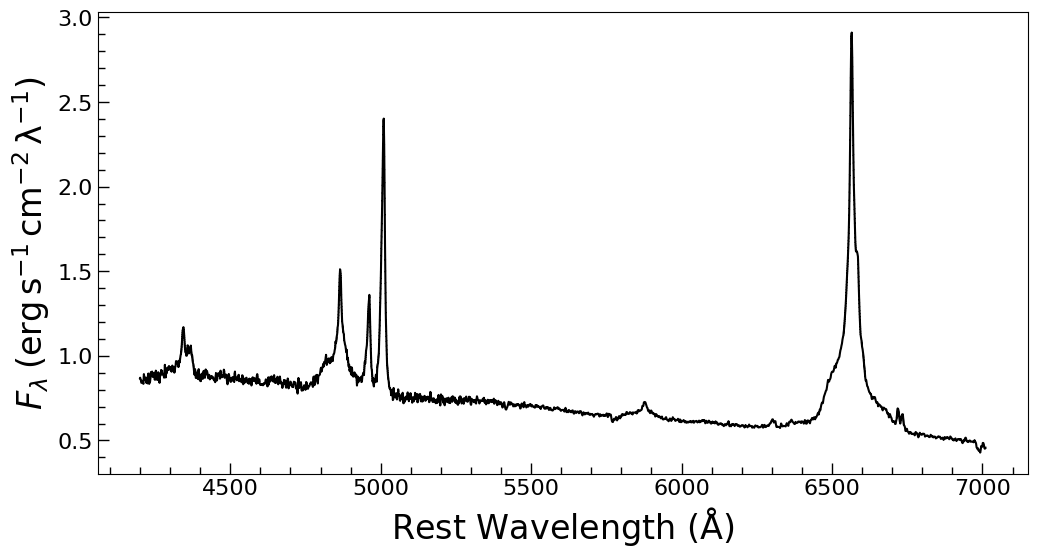

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('pg1351sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.056    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.0882 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7010
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()


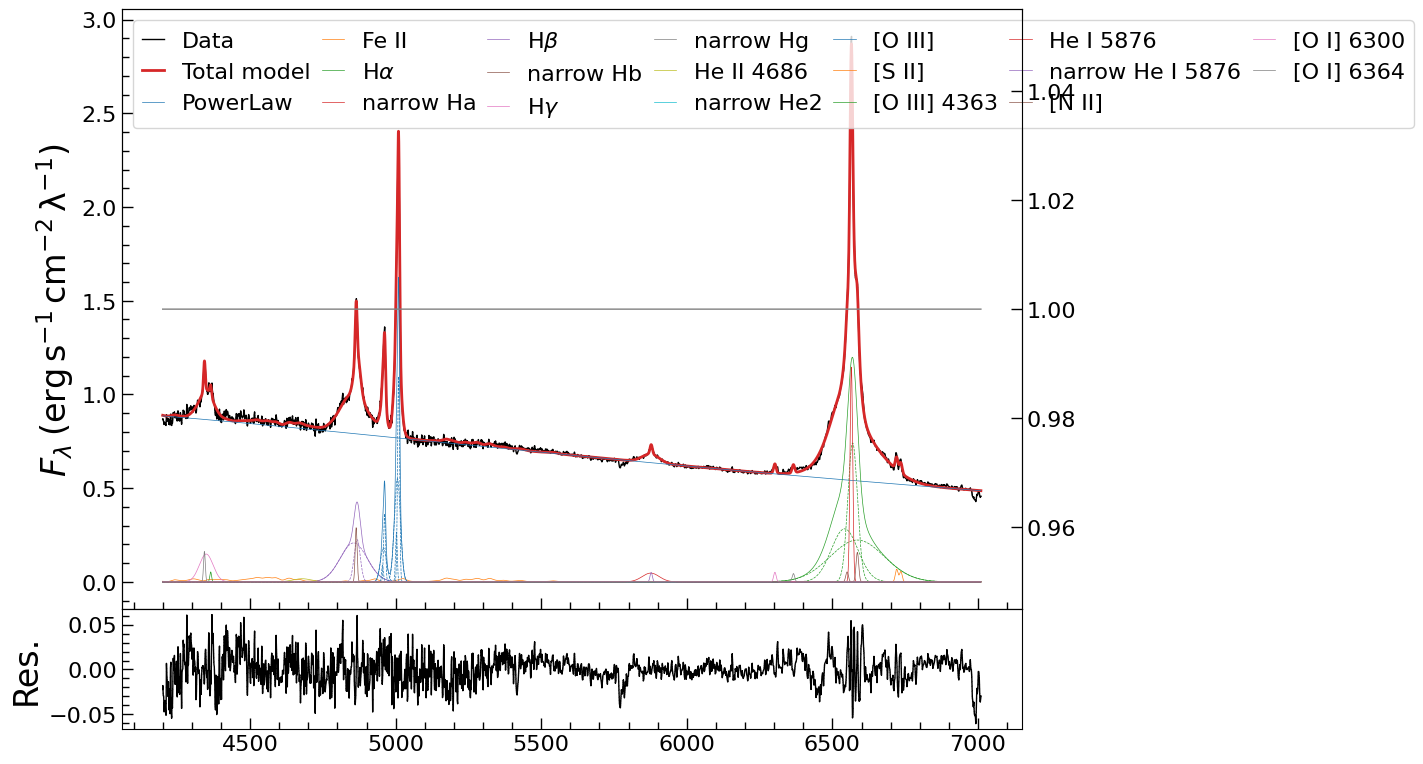

<PowerLaw1D(amplitude=0.57243299, x_0=5500., alpha=2.30578845, name='PowerLaw')>
<IronTemplate(amplitude=0.03213799, stddev=740.64042253, z=0.00070929, name='Fe II')>
<Line_MultiGauss(amp_c=0.52059228, dv_c=307.37896084, sigma_c=760.28895419, wavec=6562.819, amp_w0=0.383224, dv_w0=-1270.9810683, sigma_w0=2095.77049168, amp_w1=0.30072278, dv_w1=685.62066399, sigma_w1=4238.29282693, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.80534114, dv=106.86831248, sigma=206.97780392, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.21639061, dv_c=317.49510618, sigma_c=655.22275297, wavec=4862.721, amp_w0=0.92570438, dv_w0=-778.5892304, sigma_w0=2859.10438243, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.27799798, dv=106.86831248, sigma=206.97780392, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.16864711, dv_c=514.27023582, sigma_c=1633.21522332, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.1846556, dv=106.86831248, sigma=206.97780392, wavec=4341.785, na

In [3]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order
pl = models.PowerLaw1D(amplitude=0.69, x_0=5500, alpha=1.01, fixed={'x_0': True},name='PowerLaw')  
iron = sagan.IronTemplate(amplitude=0.06, stddev=1000, z=0, name='Fe II')

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=3, amp_c=0.83, dv_c=300, sigma_c=750, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.53, dv_w0=-500, sigma_w0=2900,
                             amp_w1=0.53, dv_w1=500, sigma_w1=2900)
#b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.83, dv_c=280, sigma_c=750, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
#                             amp_w0=0.53, dv_w0=-530, sigma_w0=2900)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.25, dv_c=300, sigma_c=650, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.88, dv_w0=-800, sigma_w0=3000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.15, dv_c=640, sigma_c=1300, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.02, dv_c=-500, sigma_c=2200, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.06, dv_c=2, sigma_c=1300, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=1.1, amp_c1=0.369, dv_c=109, sigma_c=200, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.26, dv_w0=-436, sigma_w0=180, amp_w1=0.5, dv_w1=-230, sigma_w1=650)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.1, amp_c1=0.08,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.18, amp_c1=0.06, dv_c=109, sigma_c=203,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=1.04, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.28, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.16, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.04, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_he1= sagan.Line_Gaussian(amplitude=0.06, wavec=5875.624, name='narrow He I 5876')  

n_o1_6300 = sagan.Line_Gaussian(amplitude=0.042, wavec=wave_dict['OI_6300'], name=f'[O I] 6300')
n_o1_6364 = sagan.Line_Gaussian(amplitude=0.04, wavec=wave_dict['OI_6364'], name=f'[O I] 6364')

line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1+n_he1  # Masked

m_init = (pl + iron + line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+line_n2+n_o1_6300+n_o1_6364)*poly

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_he1,n_o1_6300,n_o1_6364]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
#fltr = (wave_use > 5770) & (wave_use < 6000)
#weights[fltr] = 0.0
m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())

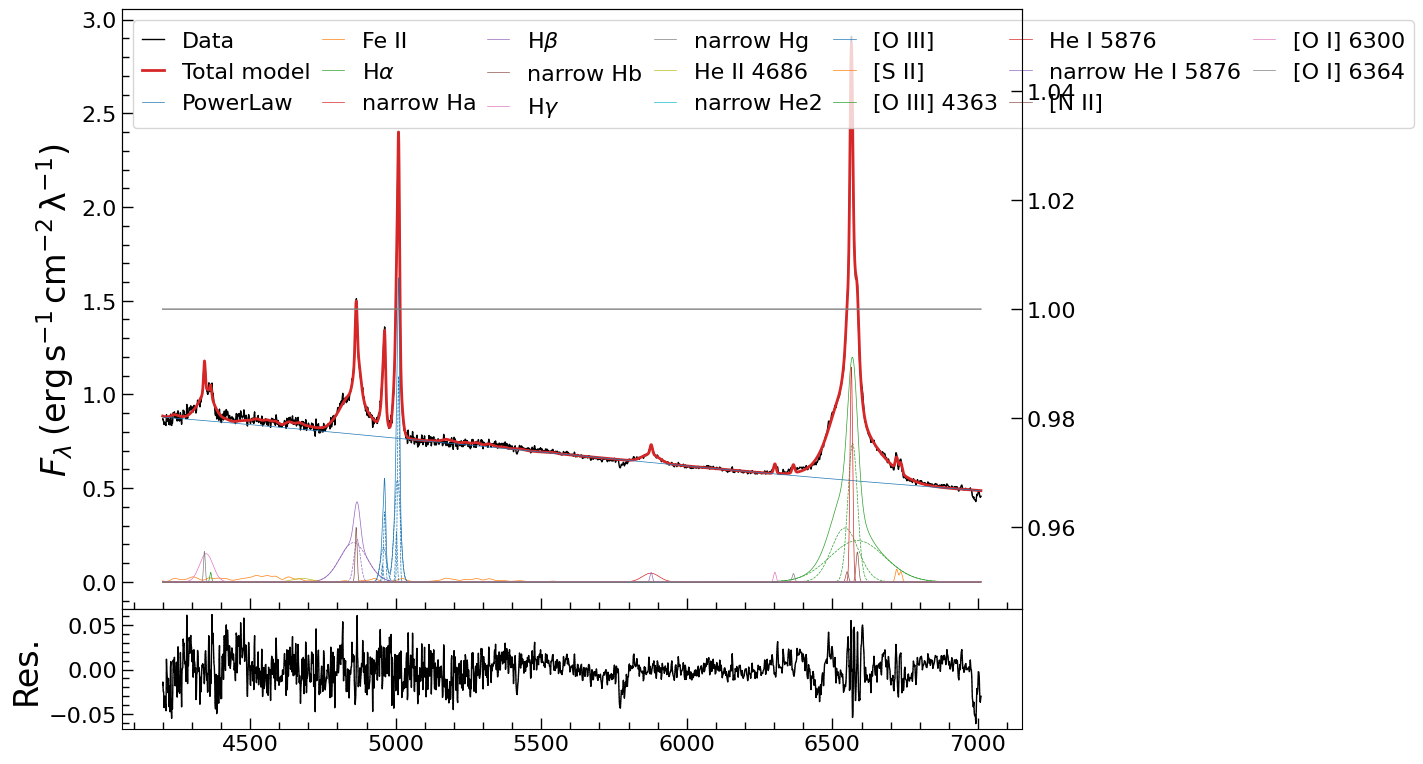

<PowerLaw1D(amplitude=0.20575548, x_0=5500., alpha=-0.57016314, name='PowerLaw')>
<IronTemplate(amplitude=0.00954745, stddev=751.37241645, z=0.00045439, name='Fe II')>
<Line_MultiGauss(amp_c=0.3111603, dv_c=312.71870991, sigma_c=758.23110923, wavec=6562.819, amp_w0=0.38592368, dv_w0=-1207.03639528, sigma_w0=2104.64353984, amp_w1=0.30070788, dv_w1=864.4925038, sigma_w1=4280.35825403, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.48242744, dv=107.26650336, sigma=207.09688173, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.05507359, dv_c=323.94080698, sigma_c=661.70360429, wavec=4862.721, amp_w0=0.9231384, dv_w0=-753.37609012, sigma_w0=2873.28035651, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.07078668, dv=107.26650336, sigma=207.09688173, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.03146879, dv_c=543.13852992, sigma_c=1592.32902978, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.03390752, dv=107.26650336, sigma=207.09688173, wavec=4341.785,

In [4]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
poly = models.Polynomial1D(degree=3, name='multi')  # The name must be `multi`; no more than 5th order
pl = models.PowerLaw1D(amplitude=0.69, x_0=5500, alpha=1.01, fixed={'x_0': True},name='PowerLaw')  
iron = sagan.IronTemplate(amplitude=0.06, stddev=1000, z=0, name='Fe II')

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=3, amp_c=0.83, dv_c=300, sigma_c=750, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.53, dv_w0=-500, sigma_w0=2900,
                             amp_w1=0.53, dv_w1=500, sigma_w1=2900)
#b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.83, dv_c=280, sigma_c=750, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
#                             amp_w0=0.53, dv_w0=-530, sigma_w0=2900)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.25, dv_c=300, sigma_c=650, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.88, dv_w0=-800, sigma_w0=3000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.15, dv_c=640, sigma_c=1300, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.02, dv_c=-500, sigma_c=2200, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.06, dv_c=2, sigma_c=1300, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=1.1, amp_c1=0.369, dv_c=109, sigma_c=200, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.26, dv_w0=-436, sigma_w0=180, amp_w1=0.5, dv_w1=-230, sigma_w1=650)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.1, amp_c1=0.08,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.18, amp_c1=0.06, dv_c=109, sigma_c=203,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=1.04, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.28, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.16, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.04, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_he1= sagan.Line_Gaussian(amplitude=0.06, wavec=5875.624, name='narrow He I 5876')  

n_o1_6300 = sagan.Line_Gaussian(amplitude=0.042, wavec=wave_dict['OI_6300'], name=f'[O I] 6300')
n_o1_6364 = sagan.Line_Gaussian(amplitude=0.04, wavec=wave_dict['OI_6364'], name=f'[O I] 6364')

line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1+n_he1  # Masked

m_init = (pl + iron + line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+line_n2+n_o1_6300+n_o1_6364)*poly

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_he1,n_o1_6300,n_o1_6364]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
#fltr = (wave_use > 5770) & (wave_use < 6000)
#weights[fltr] = 0.0
m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())

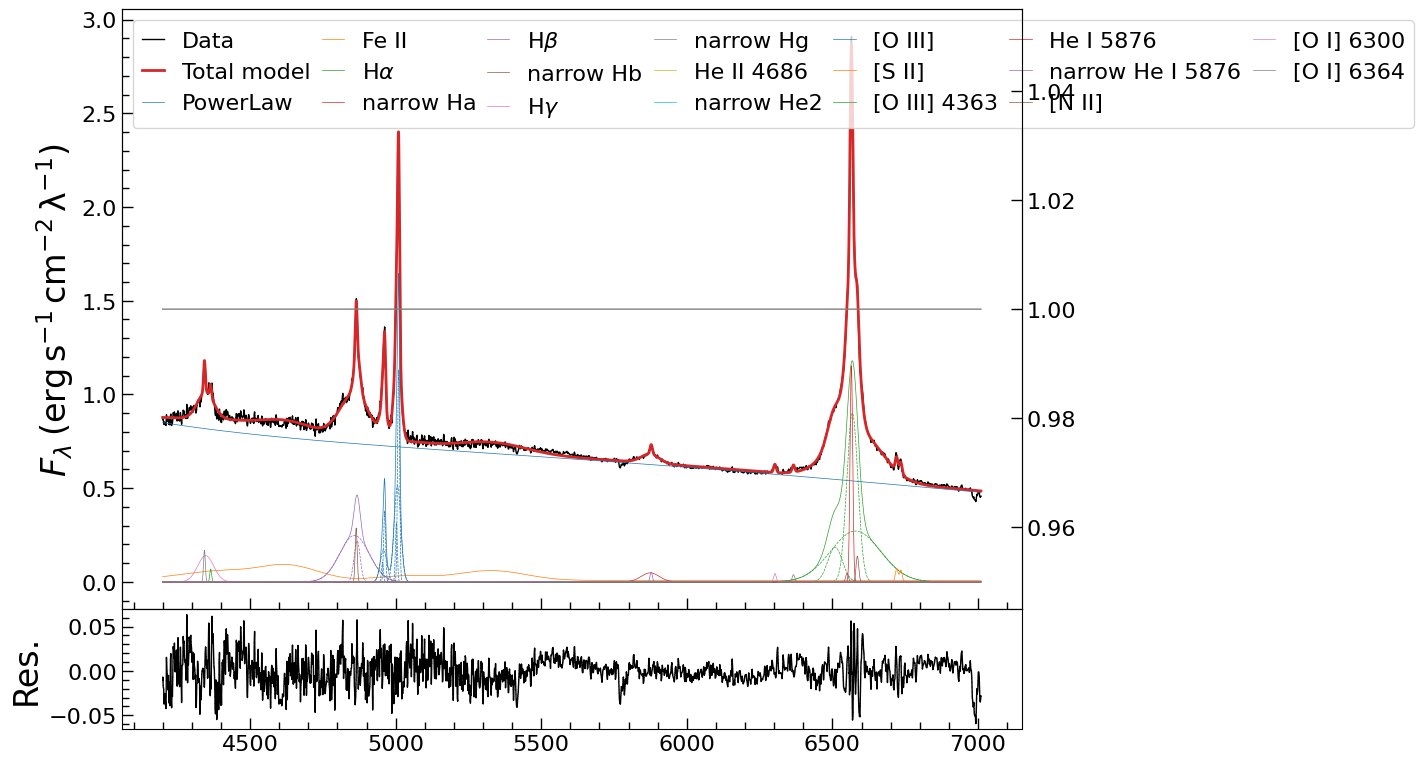

<PowerLaw1D(amplitude=0.65319607, x_0=5500., alpha=1.05973081, name='PowerLaw')>
<IronTemplate(amplitude=0.17383628, stddev=5439.5, z=0.014328, name='Fe II')>
<Line_MultiGauss(amp_c=0.90427344, dv_c=263.50834825, sigma_c=872.53329991, wavec=6562.819, amp_w0=0.2044226, dv_w0=-2703.63189082, sigma_w0=1135.43145959, amp_w1=0.3015268, dv_w1=533.61015611, sigma_w1=3900.2451639, name='H$\\alpha$')>
<Line_Gaussian(amplitude=1.15822108, dv=109.31248154, sigma=207.73002048, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.22097159, dv_c=310.40580124, sigma_c=638.73922903, wavec=4862.721, amp_w0=1.13344566, dv_w0=-579.27771708, sigma_w0=3121.51315595, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.28960114, dv=109.31248154, sigma=207.73002048, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.14341504, dv_c=391.74333548, sigma_c=1903.84506749, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.173934, dv=109.31248154, sigma=207.73002048, wavec=4341.785, name='narr

In [5]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

poly = models.Polynomial1D(degree=4, name='multi')  # The name must be `multi`; no more than 5th order
pl = models.PowerLaw1D(amplitude=0.65319607, x_0=5500, alpha=1.05973081, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')  
iron = sagan.IronTemplate(amplitude=0.17383628, stddev=5439.5, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=3, amp_c=0.83, dv_c=300, sigma_c=750, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.53, dv_w0=-500, sigma_w0=1900,
                             amp_w1=0.53, dv_w1=500, sigma_w1=3900)
#b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.83, dv_c=280, sigma_c=750, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
#                             amp_w0=0.53, dv_w0=-530, sigma_w0=2900)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.25, dv_c=300, sigma_c=650, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.88, dv_w0=-800, sigma_w0=3000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.15, dv_c=640, sigma_c=1300, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.02, dv_c=-500, sigma_c=2200, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.06, dv_c=2, sigma_c=1300, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=1.1, amp_c1=0.369, dv_c=109, sigma_c=200, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.26, dv_w0=-436, sigma_w0=180, amp_w1=0.5, dv_w1=-230, sigma_w1=650)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.1, amp_c1=0.08,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.18, amp_c1=0.06, dv_c=109, sigma_c=203,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=1.04, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.28, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.16, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.04, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_he1= sagan.Line_Gaussian(amplitude=0.06, wavec=5875.624, name='narrow He I 5876')  

n_o1_6300 = sagan.Line_Gaussian(amplitude=0.042, wavec=wave_dict['OI_6300'], name=f'[O I] 6300')
n_o1_6364 = sagan.Line_Gaussian(amplitude=0.04, wavec=wave_dict['OI_6364'], name=f'[O I] 6364')

line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1+n_he1  # Masked

m_init = (pl + iron+ line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+line_n2+n_o1_6300+n_o1_6364 )*poly
#+ line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+line_n2+n_o1_6300+n_o1_6364

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_he1,n_o1_6300,n_o1_6364]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
#fltr = (wave_use > 5770) & (wave_use < 6000)
fltr11=(wave_use>4260)&(wave_use<4430)
fltr12=(wave_use>4770)&(wave_use<5080)
fltr13=(wave_use>5550)&(wave_use<6050)
fltr14=(wave_use>6200)&(wave_use<6890)
#weights[fltr] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0
m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())